# Analysis of the re-runs of D1770-3
## AIM:
The aim of the study is to explore the sequence variation that we detect by whole genome sequencing a sample of <em>Mycobacterium tuberculosis</em>. In the case of D1770-3 the culture was grown from a single colony and the DNA was extracted as a single large isolate. Such a sample is as homogeneous as an <em>Mtb</em> sample can be.

The heterozygous positions that would be detected in this setup can arise from two sources:
1. Technical artefact (PCR/Library preparation/Sequencing)
2. De facto sequence variation in the culture.

## APPROACH:
David has mapped the fastqs using the standard outputs. I have processed the sorted bams using Qingyun's analysis pipeline (2_low_frequency_variants.sh). I wrote a couple of python scripts to filter out problematic regions (5_lable_filter.py), output relevant information [GENOMIC_POSITION, REF_BASE, ALT_BASE, FREQ] - H37RVQC_information_extraction.py for Het calls and H37RVQC_homo_extraction.py for Homo calls.

### SNP criteria:
TOOL: SAMTOOLS PILEUP

>samtools mpileup -q 30 -Q 20 -BOf \$REFERENCE \$1 > \$TMPDIR/\$BASENAME.pileup

1. Base call score >30
2. Mapping score >20

TOOL: VARSCAN

>java -jar \$VARSCAN mpileup2snp \$TMPDIR/\$BASENAME.pileup 
>    --min-coverage 50 
>    --min-reads2 4 
>    --min-avg-qual 20 
>    --min-var-freq 0.005 
>    --min-freq-for-hom 0.9 
>    --p-value 99e-02 
>    --strand-filter 1 > \$BASENAME.var

1. Minimum coverage 50
2. Minimum average quality 20
3. Minimum frequency 0.5%
4. Minimal reads 4

TOOL: Qingyun's PERL scripts

1. Ensure 2 reads in each direction

TOOL: Qingyun's R script

1. Use a KS-test to ensure that variant calls do not occur due to sequence variation in the tail part of the reads.

TOOL: Custom filtering script

1. Remove SNPs in problematic regions.

This pipeline has been used to generate the Chinese dataset SNPs.

## DATA WRANGLING
I have used the following script to process the data (annotate SNPs using MTB_anc as reference) and generate the dataframe csvs.

>150731_H37RV_QC_setup.py

All the data have been summarised in two dataframes: '150804_H37Rv_QC_G_dataframe.csv' and '150804_H37Rv_QC_ALL_dataframe.csv'. The first contains information per G-number while the second contains similar information per SNP.

## ANALYSIS
Start by setting up the kernel

In [1]:
#import scipy as sp
from scipy import stats as ss
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import utils as sku
import beeswarm as bs
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
import string

mpl.rcParams['font.sans-serif']='Helvetica'
mpl.rcParams['legend.numpoints'] = 1

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#Import dataframes
QC_ALL = pd.read_csv('150804_H37Rv_QC_ALL_dataframe.csv',index_col=0)
QC_G = pd.read_csv('150804_H37Rv_QC_G_dataframe.csv',index_col=0)

#Import frequency tables
QC_unfixed = np.loadtxt('150804_QC_unfixed.csv',delimiter=',')
QC_fixed = np.loadtxt('150804_QC_fixed.csv',delimiter=',')

#explore:
print QC_ALL.head()

   COVERAGE   FREQ  FREQ_BI            GENE      ID    LOCUS  LOG_FREQ  \
0      67.9  38.46        1         Rv2250A  G02222  2525723  3.649619   
1      67.9   7.58        1          Rv2932  G02222  3253342  2.025513   
2      67.9   7.94        1          Rv2932  G02222  3253343  2.071913   
3      67.9  12.50        1  Rv3191c-Rv3192  G02222  3558777  2.525729   
4      67.9  12.28        1  Rv3191c-Rv3192  G02222  3558778  2.507972   

   TRANSITION           TYPE WT_CODON  FIXED  TYPE_NSY  TYPE_SYN  TYPE_IGR  
0           0  nonsynonymous      GGG      0         1         0         0  
1           0     synonymous      GCG      0         0         1         0  
2           1     synonymous      CTG      0         0         1         0  
3           0            IGR      NaN      0         0         0         1  
4           0            IGR      NaN      0         0         0         1  

[5 rows x 14 columns]


In [4]:
print QC_G.head()

   COVERAGE  FIXED_N  FIXED_TiTv  FIXED_pN  FIXED_pS      ID  UNFIXED_HET  \
0      67.9      683    0.636488  0.286147  0.455078  G02222     0.000001   
1      98.9      802    0.627771  0.282696  0.464442  G02292     0.000001   
2     138.1      922    0.619189  0.283966  0.461109  G02484     0.000004   
3     170.2      934    0.622587  0.284410  0.460173  G02580     0.000006   
4     196.4      939    0.620192  0.283167  0.463315  G02676     0.000017   

   UNFIXED_MEANS  UNFIXED_MEDIANS  UNFIXED_NOH  UNFIXED_TiTv  UNFIXED_VAR  \
0      18.644167           10.755           12      0.333333   248.155058   
1      13.397222            5.690           36      0.138889   475.959009   
2       5.574764            3.200          212      0.169811   129.519320   
3       3.347193            2.780          456      0.153509    20.923669   
4       2.751296            2.390         1474      0.167571    14.895152   

   UNFIXED_pN  UNFIXED_pS  FIXED_pNS  UNFIXED_pNS      RUNID INSTRUMENT  \

Start by looking at the distribution of the SNP frequencies.

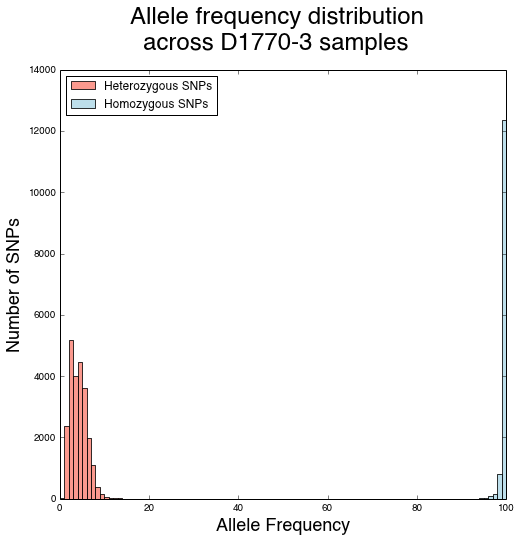

In [5]:
plt.figure('SNP_freqs', figsize=(8,8),dpi=200)
plt.hist(QC_unfixed[:,1:][QC_unfixed[:,1:]>0],bins=np.arange(101),facecolor='salmon',label='Heterozygous SNPs',alpha=0.8)
plt.hist(QC_fixed[:,1:][QC_fixed[:,1:]>0],bins=np.arange(101),facecolor='lightblue',label='Homozygous SNPs',alpha=0.8)
plt.xlabel('Allele Frequency', size=18)
plt.ylabel('Number of SNPs', size=18)
plt.legend(loc=2)
plt.suptitle('Allele frequency distribution \nacross D1770-3 samples', size=24)
plt.subplots_adjust(top=0.87)

#plt.savefig('150804_H37RV_QC_6_0.pdf')

Note that the Heterozygous SNPs are pooled across all samples. I will plot them separately to see the distributions for individual samples.

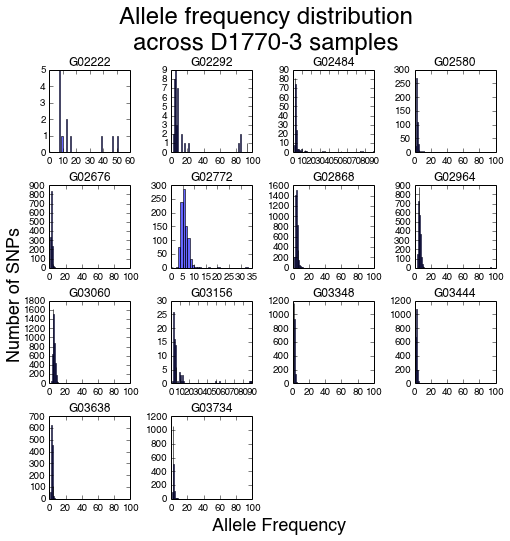

In [6]:
plt.figure('SNP_freqs_perG', figsize=(8,8),dpi=200)
for ind,val in enumerate(QC_G.ID):
    plt.subplot(4,4,ind+1)
    plt.hist(QC_unfixed[:,ind+1][QC_unfixed[:,ind+1]>0],bins=np.arange(101),label='Heterozygous SNPs',alpha=0.6)
    plt.title(val)
    if ind==4: plt.ylabel('Number of SNPs', size=18,horizontalalignment='right')
plt.xlabel('Allele Frequency', size=18,horizontalalignment='left')
plt.suptitle('Allele frequency distribution \nacross D1770-3 samples', size=24)
plt.subplots_adjust(top=0.87,hspace=0.4,wspace=.5)

#plt.savefig('150804_H37RV_QC_8_0.pdf')

How many of these are shared across different samples?

(1, 15)

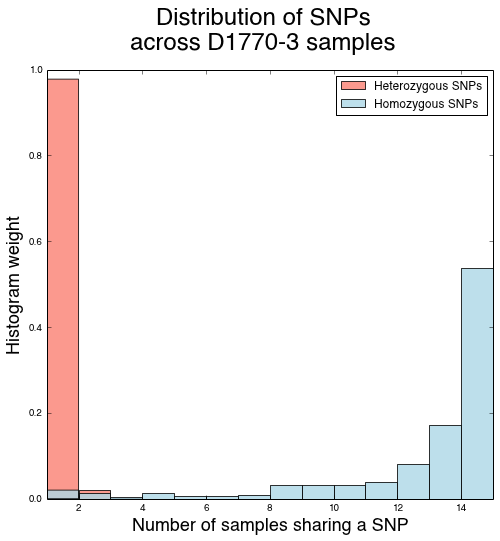

In [8]:
plt.figure('SNP shared', figsize=(8,8),dpi=200)
plt.hist(np.sum(QC_unfixed[:,1:]>0, axis=1),bins=range(1,16),normed=True, facecolor='salmon',label='Heterozygous SNPs',alpha=0.8)
plt.hist(np.sum(QC_fixed[:,1:]>0, axis=1),bins=range(1,16),normed=True, facecolor='lightblue',label='Homozygous SNPs',alpha=0.8)
plt.legend()
plt.xlabel('Number of samples sharing a SNP', size=18)
plt.ylabel('Histogram weight', size=18)
plt.suptitle('Distribution of SNPs \nacross D1770-3 samples', size=24)
plt.subplots_adjust(top=0.87)
plt.xlim(1,15)

#plt.savefig('150804_H37RV_QC_10_0.pdf')

It is apparent that most heterozygous SNPs are singletons while most homozygous SNPs are shared across almost all samples.

How does coverage compare to the number of heterozygous sites?

### Coverage vs number of SNPs

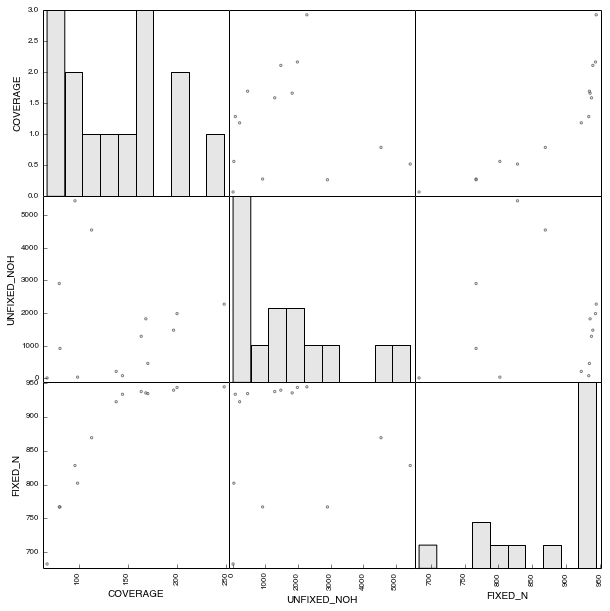

In [9]:
fig = pd.tools.plotting.scatter_matrix(
    QC_G[['COVERAGE','UNFIXED_NOH','FIXED_N']]
    ,hist_kwds={'color':(.9,.9,.9,1)}, figsize=(10,10),facecolor='white')

#plt.savefig('150804_H37RV_QC_12_0.pdf')

Obvious pattern for COVERAGE ~ N_FIXED (homozygous SNPs) with a steady increase until it stabilises around 1050 SNPs. This makes sense in light of the fact that H37Rv data were mapped on the ancestor. <strong>The threshold for the detection of the majority of the homozygous SNPs seems to be around 150-fold coverage.</strong>

The trend for the heterozygous SNPs is less clear. I will start by running a univariate regression model.

In [47]:
model = sm.OLS.from_formula('UNFIXED_NOH ~ COVERAGE', QC_G)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:            UNFIXED_NOH   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.081
Method:                 Least Squares   F-statistic:                   0.02947
Date:                Tue, 04 Aug 2015   Prob (F-statistic):              0.867
Time:                        16:47:49   Log-Likelihood:                -123.31
No. Observations:                  14   AIC:                             250.6
Df Residuals:                      12   BIC:                             251.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1892.0821   1354.688      1.397      0.1

Basically seems to be noise. However if we plot the data it seems like there are two sets of samples. <strong>G03060, G02868, G02964</strong> and <strong>G02772</strong> seem to be behaving differently.

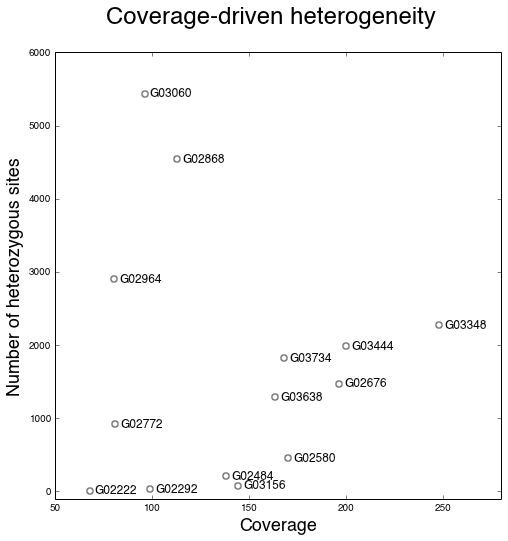

In [9]:
plt.figure('Het_vs_coverage', figsize=(8,8),dpi=200)
plt.plot(QC_G.COVERAGE, QC_G.UNFIXED_NOH,'o',mfc='none',mec='gray',mew=1.5)
for ind,val in enumerate(QC_G.ID):
    plt.text(QC_G.COVERAGE[QC_G.ID==val]+3,QC_G.UNFIXED_NOH[QC_G.ID==val],val,verticalalignment='center',size=12)
plt.xlim(50,280)
plt.ylim(-100,6000)
plt.ylabel('Number of heterozygous sites', size=18)
plt.xlabel('Coverage', size=18)
plt.suptitle('Coverage-driven heterogeneity', size=24)

#plt.savefig('150804_H37RV_QC_16_1.pdf')

Let's modify the regression model to account for the <strong>HI_ERROR</strong> samples.

In [11]:
model = sm.OLS.from_formula('UNFIXED_NOH ~ COVERAGE*HI_ERROR', QC_G)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:            UNFIXED_NOH   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     12.21
Date:                Tue, 04 Aug 2015   Prob (F-statistic):            0.00111
Time:                        17:21:07   Log-Likelihood:                -112.55
No. Observations:                  14   AIC:                             233.1
Df Residuals:                      10   BIC:                             235.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept         -1398.7556    961.01

Adjusted R2 massively improved (from -0.081 to 0.721) furthermore the model was not significant before and now it is. The slopes for both are significantly different. Re-plot by adding the regression lines.

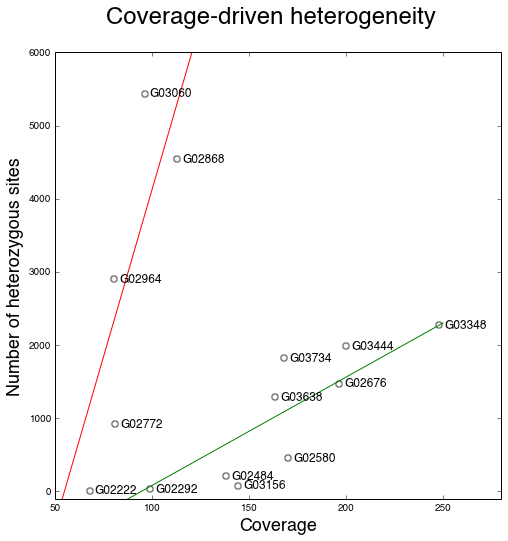

In [13]:
plt.figure('Het_vs_coverage_regression', figsize=(8,8),dpi=200)
plt.plot(QC_G.COVERAGE, QC_G.UNFIXED_NOH,'o',mfc='none',mec='gray',mew=1.5)
plt.plot(np.arange(50,251), np.arange(50,251)*result.params[1]+result.params[0])
plt.plot(np.arange(50,251), np.arange(50,251)*(result.params[1]+result.params[3])+(result.params[0]+result.params[2]))
for ind,val in enumerate(QC_G.ID):
    plt.text(QC_G.COVERAGE[QC_G.ID==val]+3,QC_G.UNFIXED_NOH[QC_G.ID==val],val,verticalalignment='center',size=12)
plt.xlim(50,280)
plt.ylim(-100,6000)
plt.ylabel('Number of heterozygous sites', size=18)
plt.xlabel('Coverage', size=18)
plt.suptitle('Coverage-driven heterogeneity', size=24)

#plt.savefig('150804_H37RV_QC_20_1.pdf')

Interestingly the regression parameters are even better if I run the regression using log(#Het).

In [14]:
model = sm.OLS.from_formula('np.log(UNFIXED_NOH) ~ COVERAGE*HI_ERROR', QC_G)
result = model.fit()
print result.summary()

                             OLS Regression Results                            
Dep. Variable:     np.log(UNFIXED_NOH)   R-squared:                       0.853
Model:                             OLS   Adj. R-squared:                  0.808
Method:                  Least Squares   F-statistic:                     19.27
Date:                 Tue, 04 Aug 2015   Prob (F-statistic):           0.000177
Time:                         17:21:34   Log-Likelihood:                -14.744
No. Observations:                   14   AIC:                             37.49
Df Residuals:                       10   BIC:                             40.04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.6134

What is even more interesting is that the slopes are no longer significantly different (while the Adjusted R2 and the p-value point to a model that behaves better than the previous ones). Not sure why this should be, but let's look at the plot for this.

I have colored the dots based on the platform the samples were sequenced on.

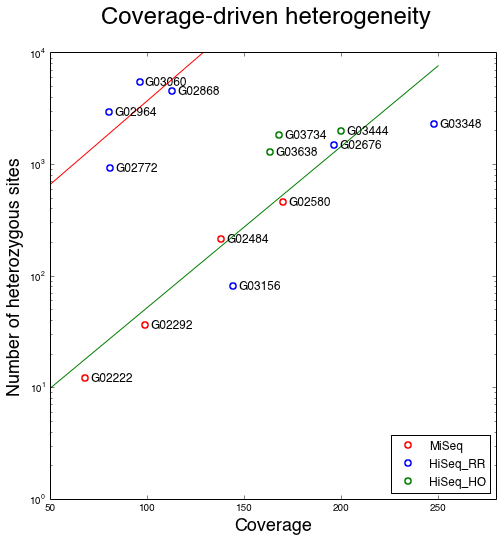

In [15]:
plt.figure('Het_vs_coverage_regression_log', figsize=(8,8),dpi=200)
plt.plot(QC_G.COVERAGE[QC_G.INSTRUMENT=='MiSeq'], QC_G.UNFIXED_NOH[QC_G.INSTRUMENT=='MiSeq'],'o', label='MiSeq', mfc='none',mec='red',mew=1.5)
plt.plot(QC_G.COVERAGE[QC_G.INSTRUMENT=='HiSeq_RR'], QC_G.UNFIXED_NOH[QC_G.INSTRUMENT=='HiSeq_RR'],'o', label='HiSeq_RR', mfc='none',mec='blue',mew=1.5)
plt.plot(QC_G.COVERAGE[QC_G.INSTRUMENT=='HiSeq_HO'], QC_G.UNFIXED_NOH[QC_G.INSTRUMENT=='HiSeq_HO'],'o', label='HiSeq_HO', mfc='none',mec='green',mew=1.5)
plt.plot(np.arange(50,251), np.exp(np.arange(50,251)*result.params[1]+result.params[0]),'g-')
plt.plot(np.arange(50,251), np.exp(np.arange(50,251)*(result.params[1]+result.params[3])+(result.params[0]+result.params[2])),'r-')
for ind,val in enumerate(QC_G.ID):
    plt.text(QC_G.COVERAGE[QC_G.ID==val]+3,QC_G.UNFIXED_NOH[QC_G.ID==val],val,verticalalignment='center',size=12)
plt.xlim(50,280)
plt.ylim(1,10000)
plt.yscale('log')
plt.ylabel('Number of heterozygous sites', size=18)
plt.xlabel('Coverage', size=18)
plt.suptitle('Coverage-driven heterogeneity', size=24)
plt.legend(loc=4)

#plt.savefig('150804_H37RV_QC_24_1.pdf')

Not sure what happened here. The fact that the error rates are comparable in log space suggests that there was a fundamental difference in the way these samples were generated or ran. Given that the effect seems to be platform independent, it would suggest that errors are being generated on an exponential scale. <strong>Were libraries prepared with different batches of PCR enzyme</strong>? Different number of runs. All the faulty runs (HiSeq0018,0020,0022,0024) were performed consequently earlier this year (26/01/2015-24/03/2015), worth looking into it?